# Backtesting with zipline - Pipeline API with Custom Data

The [Pipeline API](https://www.quantopian.com/docs/user-guide/tools/pipeline) facilitates the definition and computation of alpha factors for a cross-section of securities from historical data. The Pipeline significantly improves efficiency because it optimizes computations over the entire backtest period rather than tackling each event separately. In other words, it continues to follow an event-driven architecture but vectorizes the computation of factors where possible. 

A Pipeline uses Factors, Filters, and Classifiers classes to define computations that produce columns in a table with PIT values for a set of securities. Factors take one or more input arrays of historical bar data and produce one or more outputs for each security. There are numerous built-in factors, and you can also design your own `CustomFactor` computations.

The following figure depicts how loading the data using the `DataFrameLoader`, computing the predictive `MLSignal` using the Pipeline API, and various scheduled activities integrate with the overall trading algorithm executed via the `run_algorithm()` function. We go over the details and the corresponding code in this section.

![The Pipeline Workflow](../../assets/zip_pipe_flow.png)

You need to register your Pipeline with the `initialize()` method and can then execute it at each time step or on a custom schedule. Zipline provides numerous built-in computations such as moving averages or Bollinger Bands that can be used to quickly compute standard factors, but it also allows for the creation of custom factors as we will illustrate next. 

Most importantly, the Pipeline API renders alpha factor research modular because it separates the alpha factor computation from the remainder of the algorithm, including the placement and execution of trade orders and the bookkeeping of portfolio holdings, values, and so on.

The goal is to combine the daily return predictions with the OHCLV data from our Quandl bundle and then to go long on up to 10 equities with the highest predicted returns and short on those with the lowest predicted returns, requiring at least five stocks on either side similar to the backtrader example above. See comments in the notebook for implementation details.

## Imports & Settings

In [248]:
import warnings
warnings.filterwarnings('ignore')

In [249]:
from collections import defaultdict
from time import time

import numpy as np
import pandas as pd
import pandas_datareader.data as web
from logbook import Logger, StderrHandler, INFO

import matplotlib.pyplot as plt
import seaborn as sns

from zipline import run_algorithm
from zipline.api import (attach_pipeline,
                         pipeline_output,
                         date_rules,
                         time_rules,
                         record,
                         schedule_function,
                         commission,
                         slippage,
                         set_slippage,
                         set_commission,
                         order_target,
                         order_target_percent)
from zipline.data import bundles
from zipline.utils.run_algo import load_extensions
from zipline.pipeline import Pipeline, CustomFactor
from zipline.pipeline.data import Column, DataSet
from zipline.pipeline.domain import US_EQUITIES
from zipline.pipeline.filters import StaticAssets
from zipline.pipeline.loaders.frame import DataFrameLoader

import pyfolio as pf
from pyfolio.plotting import plot_rolling_returns, plot_rolling_sharpe
from pyfolio.timeseries import forecast_cone_bootstrap

In [250]:
sns.set_style('whitegrid')
pd.set_option('display.expand_frame_repr', False)
np.random.seed(42)

### Load zipline extensions

Only need this in notebook to find bundle.

In [251]:
load_extensions(default=True,
                extensions=[],
                strict=True,
                environ=None)

In [252]:
log_handler = StderrHandler(format_string='[{record.time:%Y-%m-%d %H:%M:%S.%f}]: ' +
                            '{record.level_name}: {record.func_name}: {record.message}',
                            level=INFO)
log_handler.push_application()
log = Logger('Algorithm')

## Algo Params

We plan to hold up to 20 long and 20 short positions whenever there are at least 10 on either side that meet the criteria (positive/negative prediction for long/short position).

In [253]:
N_LONGS = 20
N_SHORTS = 20
MIN_POSITIONS = 10

## Load Data

### Quandl Wiki Bundle

Load the Wiki Quandl `bundle` data that we ingested earlier using `zipline ingest`. This gives us access to the security SID values, among other things.

In [254]:
bundle_data = bundles.load('quandl')

### ML Predictions

We load our predictions for the 2015-17 period and extract the Zipline IDs for the ~250 stocks in our universe during this period using the `bundle.asset_finder.lookup_symbols()` method:

In [255]:
def load_predictions(bundle):
    predictions = pd.read_hdf('../00_data/backtest.h5', 'data')[['predicted']].dropna()
    tickers = predictions.index.get_level_values(0).unique().tolist()

    assets = bundle.asset_finder.lookup_symbols(tickers, as_of_date=None)
    predicted_sids = pd.Index([asset.sid for asset in assets])
    ticker_map = dict(zip(tickers, predicted_sids))
    return (predictions
            .unstack('ticker')
            .rename(columns=ticker_map)
            .predicted
            .tz_localize('UTC')), assets

In [256]:
predictions, assets = load_predictions(bundle_data)

In [257]:
predictions.index = predictions.index.tz_localize(None)
predictions

ticker,8,12,45,71,85,98,136,138,145,149,...,216,1685,946,811,2713,2955,2411,2530,1417,1701
date,,,,,,,,,,,,,,,,,,,,,
2014-12-09,-0.001727,0.001195,NaN,NaN,0.002030,-0.000461,NaN,NaN,NaN,0.001364,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.000397,NaN,-0.005228,NaN
2014-12-10,-0.001063,0.000259,NaN,NaN,0.001740,-0.001381,NaN,NaN,NaN,0.000895,...,NaN,NaN,NaN,NaN,NaN,NaN,0.002183,NaN,-0.003744,NaN
2014-12-11,-0.001225,0.000223,NaN,NaN,0.000543,-0.001174,NaN,NaN,NaN,0.000273,...,NaN,NaN,NaN,NaN,NaN,NaN,0.001639,NaN,-0.004773,NaN
2014-12-12,-0.000943,0.000637,NaN,NaN,0.000495,-0.001333,NaN,NaN,NaN,0.000985,...,NaN,NaN,NaN,NaN,NaN,NaN,0.002674,NaN,-0.003588,NaN
2014-12-15,-0.001251,0.000461,NaN,NaN,-0.000683,-0.001441,NaN,NaN,NaN,0.001362,...,NaN,NaN,NaN,NaN,NaN,NaN,0.001579,NaN,-0.004493,0.000991
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-11-27,-0.001560,-0.000589,-0.000379,-0.002232,-0.002286,NaN,NaN,-0.000940,0.000591,-0.001683,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-28,-0.001654,-0.001064,-0.000371,-0.001769,-0.002168,-0.000505,NaN,0.000758,-0.000845,-0.001584,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-29,-0.002464,-0.000991,-0.002488,-0.002021,-0.001524,-0.000816,NaN,-0.001659,-0.000382,-0.001050,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [258]:
len(assets)
assets

[Equity(8 [AAPL]),
 Equity(12 [ABBV]),
 Equity(45 [ADBE]),
 Equity(71 [AET]),
 Equity(85 [AGN]),
 Equity(98 [AIG]),
 Equity(136 [ALXN]),
 Equity(138 [AMAT]),
 Equity(145 [AMD]),
 Equity(149 [AMGN]),
 Equity(162 [AMT]),
 Equity(167 [AMZN]),
 Equity(184 [ANTM]),
 Equity(195 [APC]),
 Equity(261 [ATVI]),
 Equity(270 [AVGO]),
 Equity(298 [BA]),
 Equity(300 [BAC]),
 Equity(365 [BIDU]),
 Equity(367 [BIIB]),
 Equity(399 [BMY]),
 Equity(457 [C]),
 Equity(482 [CAT]),
 Equity(529 [CELG]),
 Equity(567 [CHTR]),
 Equity(606 [CMCSA]),
 Equity(609 [CMG]),
 Equity(652 [COP]),
 Equity(657 [COST]),
 Equity(690 [CRM]),
 Equity(705 [CSCO]),
 Equity(761 [CVS]),
 Equity(763 [CVX]),
 Equity(801 [DE]),
 Equity(827 [DIS]),
 Equity(895 [EA]),
 Equity(898 [EBAY]),
 Equity(975 [EQT]),
 Equity(1024 [EXPE]),
 Equity(1031 [F]),
 Equity(1037 [FB]),
 Equity(1125 [FOXA]),
 Equity(1193 [GE]),
 Equity(1211 [GILD]),
 Equity(1226 [GM]),
 Equity(1244 [GOOG]),
 Equity(1245 [GOOGL]),
 Equity(1264 [GS]),
 Equity(1296 [HAL]),
 E

### Define Custom Dataset

To merge additional columns with our bundle, we define a custom `SignalData` class that inherits from `zipline.pipeline.DataSset` and contains a single `zipline.pipeline.Column` of type `float` and has the domain `US_EQUITIES`:

In [259]:
class SignalData(DataSet):
    predictions = Column(dtype=float)
    domain = US_EQUITIES

### Define Pipeline Loaders

While the bundle’s OHLCV data can rely on the built-in `USEquityPricingLoader`, we need to define our own `zipline.pipeline.loaders.frame.DataFrameLoader`:

In [260]:
signal_loader = {SignalData.predictions: DataFrameLoader(SignalData.predictions, 
                                                         predictions)}

In fact, we need to slightly modify the Zipline library’s source code to bypass the assumption that we will only load price data. To this end, we will add a `custom_loader` parameter to the `run_algorithm` and ensure that this loader is used when the `Pipeline` needs one of `SignalData`’s `Column` instances.

## Pipeline Setup

Our Pipeline is going to have two Boolean columns that identify the assets we would like to trade as long and short positions. 

To get there, we first define a `CustomFactor` called `MLSignal` that just receives the current `SignalData.predictions`. The motivation is to allow us to use some of the convenient `Factor` methods designed to rank and filter securities.

### Custom ML Factor

In [261]:
class MLSignal(CustomFactor):
    """Converting signals to Factor
        so we can rank and filter in Pipeline"""
    inputs = [SignalData.predictions]
    window_length = 1

    def compute(self, today, assets, out, preds):
        out[:] = preds

### Create Pipeline

Now we create a `compute_signals()` that returns a `zipline.pipeline.Pipeline` which filters the assets that meet our long/short criteria. We will call ths function periodically while executing the backtest.

More specifically, we set up our Pipeline by instantiating the `CustomFactor` that requires no arguments other than the defaults. We combine its `top()` and `bottom()` methods with a filter to select the highest positive and lowest negative predictions:

In [262]:
def compute_signals():
    signals = MLSignal()
#     predictions = SignalData.predictions.latest
    return Pipeline(columns={
        'longs' : signals.top(N_LONGS, mask=signals > 0),
        'shorts': signals.bottom(N_SHORTS, mask=signals < 0)},
            screen=StaticAssets(assets)
    )

## Initialize Algorithm

The `initialize()` function is part of the Algorithm API. It permits us to add entries to the `context` dictionary available to all backtest components, set parameters like commission and slippage, and schedule functions. We also attach our Pipeline to the algorithm:

In [263]:
def initialize(context):
    """
    Called once at the start of the algorithm.
    """
    context.n_longs = N_LONGS
    context.n_shorts = N_SHORTS
    context.min_positions = MIN_POSITIONS
    context.universe = assets

    set_slippage(slippage.FixedSlippage(spread=0.00))
    set_commission(commission.PerShare(cost=0, min_trade_cost=0))

    schedule_function(rebalance,
                      date_rules.every_day(),
                      time_rules.market_open(hours=1, minutes=30))

    schedule_function(record_vars,
                      date_rules.every_day(),
                      time_rules.market_close())

    pipeline = compute_signals()
    attach_pipeline(pipeline, 'signals')

### Get daily Pipeline results

The algorithm calls the `before_trading_start()` function every day before market opens and we use it to obtain the current pipeline values, i.e., the assets suggested for long and short positions based on the ML model predictions:

In [264]:
# def before_trading_start(context, data):
#     """
#     Called every day before market open.
#     """
#     output = pipeline_output('signals')
#     context.trades = (output['longs'].astype(int)
#                       .append(output['shorts'].astype(int).mul(-1))
#                       .reset_index()
#                       .drop_duplicates()
#                       .set_index('index')
#                       .squeeze())

def before_trading_start(context, data):
    """
    Called every day before market open.
    """
    output = pipeline_output('signals')
    # Create a series with 1 for longs, -1 for shorts, 0 otherwise
    context.trades = pd.Series(0, index=output.index)  # Initialize with zeros
    context.trades[output['longs']] = 1               # Set longs to 1
    context.trades[output['shorts']] = -1             # Set shorts to -1
    print(context.trades)

## Define Rebalancing Logic

The `rebalance()` function takes care of adjusting the portfolio positions to reflect the target long and short positions implied by the model forecasets:

In [265]:
def rebalance(context, data):
    """
    Execute orders according to schedule_function() date & time rules.
    """
    trades = defaultdict(list)

    for stock, trade in context.trades.items():
        if not trade:
            order_target(stock, 0)
        else:
            trades[trade].append(stock)
    context.longs, context.shorts = len(trades[1]), len(trades[-1])
    if context.longs > context.min_positions and context.shorts > context.min_positions:
        for stock in trades[-1]:
            order_target_percent(stock, -1 / context.shorts)
        for stock in trades[1]:
            order_target_percent(stock, 1 / context.longs)

## Record Data Points

The `record_vars()` logs information to the `pd.DataFrame` returned by `run_algorithm()` as scheduled.

In [266]:
def record_vars(context, data):
    """
    Plot variables at the end of each day.
    """
    record(leverage=context.account.leverage,
           longs=context.longs,
           shorts=context.shorts)

## Run Algorithm

At this point, we have defined all ingredients for the algorithm and are ready to call `run_algorithm()` with the desired `start` and `end` dates, references to the various functions we just created, and the `custom_loader` to ensure our model predictions are available to the backtest. 

In [267]:
from time import time
dates = predictions.index.get_level_values('date')
start_date = dates.min()
end_date = (dates.max() + pd.DateOffset(1))


# start_date_naive = pd.Timestamp(start_date.date())
# end_date_naive = pd.Timestamp(end_date.date())
start_date = dates.min().tz_localize(None)
end_date = (dates.max() + pd.DateOffset(1)).tz_localize(None)

# start_date = dates.min().tz_localize('UTC')
# end_date = (dates.max() + pd.DateOffset(1)).tz_localize('UTC')

In [268]:
start_date, end_date

(Timestamp('2014-12-09 00:00:00'), Timestamp('2017-11-30 00:00:00'))

In [269]:
start = time()
results = run_algorithm(start=start_date,
                       end=end_date,
                       initialize=initialize,
                       before_trading_start=before_trading_start,
                       capital_base=1e6,
                       data_frequency='daily',
                       bundle='quandl',
                       custom_loader=signal_loader) # need to modify zipline

print('Duration: {:.2f}s'.format(time() - start))

Equity(2 [AAL])        1
Equity(5 [AAOI])       0
Equity(8 [AAPL])       0
Equity(12 [ABBV])      0
Equity(20 [ABT])       0
                      ..
Equity(3144 [WYNN])    0
Equity(3145 [X])       0
Equity(3156 [XOM])    -1
Equity(3171 [YELP])    0
Equity(3175 [YUM])     0
Length: 253, dtype: int64
Equity(2 [AAL])        0
Equity(5 [AAOI])       0
Equity(8 [AAPL])       0
Equity(12 [ABBV])      0
Equity(20 [ABT])       0
                      ..
Equity(3144 [WYNN])    0
Equity(3145 [X])       0
Equity(3156 [XOM])    -1
Equity(3171 [YELP])    0
Equity(3175 [YUM])     0
Length: 253, dtype: int64
Equity(2 [AAL])        0
Equity(5 [AAOI])       0
Equity(8 [AAPL])       0
Equity(12 [ABBV])      0
Equity(20 [ABT])       0
                      ..
Equity(3144 [WYNN])    1
Equity(3145 [X])       0
Equity(3156 [XOM])    -1
Equity(3171 [YELP])    0
Equity(3175 [YUM])     0
Length: 253, dtype: int64
Equity(2 [AAL])        1
Equity(5 [AAOI])       0
Equity(8 [AAPL])       0
Equity(12 [ABBV])     

In [270]:
results

,period_open,period_close,long_exposure,starting_value,net_leverage,long_value,short_value,pnl,starting_cash,gross_leverage,...,algo_volatility,algorithm_period_return,excess_return,alpha,beta,treasury_period_return,benchmark_period_return,benchmark_volatility,sortino,max_leverage
2014-12-09 21:00:00+00:00,2014-12-09 14:31:00+00:00,2014-12-09 21:00:00+00:00,0.00,0.000,0.000000,0.00,0.000,0.000000e+00,1000000.000,0.000000,...,NaN,0.000000e+00,0.0,None,None,0.0,0.0,NaN,NaN,0.000000
2014-12-10 21:00:00+00:00,2014-12-10 14:31:00+00:00,2014-12-10 21:00:00+00:00,985385.91,0.000,0.014347,985385.91,-971039.150,2.328306e-10,1000000.000,1.956425,...,2.492445e-15,2.220446e-16,0.0,None,None,0.0,0.0,0.0,NaN,1.956425
2014-12-11 21:00:00+00:00,2014-12-11 14:31:00+00:00,2014-12-11 21:00:00+00:00,1002209.73,14346.760,0.002553,1002209.73,-999632.455,9.498995e+03,985653.240,1.983006,...,8.705973e-02,9.498995e-03,0.0,None,None,0.0,0.0,0.0,NaN,1.983006
2014-12-12 21:00:00+00:00,2014-12-12 14:31:00+00:00,2014-12-12 21:00:00+00:00,994626.63,2577.275,0.001869,994626.63,-992728.585,6.235255e+03,1006921.720,1.956570,...,7.499208e-02,1.573425e-02,0.0,None,None,0.0,0.0,0.0,NaN,1.983006
2014-12-15 21:00:00+00:00,2014-12-15 14:31:00+00:00,2014-12-15 21:00:00+00:00,1009530.93,1898.045,0.002863,1009530.93,-1006621.210,5.877450e+02,1013836.205,1.983773,...,6.913890e-02,1.632200e-02,0.0,None,None,0.0,0.0,0.0,NaN,1.983773
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-11-24 18:00:00+00:00,2017-11-24 14:31:00+00:00,2017-11-24 18:00:00+00:00,375013.41,-10559.150,-0.354248,375013.41,-749357.520,4.820040e+03,1062467.817,1.064011,...,1.170038e-01,5.672871e-02,0.0,None,None,0.0,0.0,0.0,0.299866,2.153524
2017-11-27 21:00:00+00:00,2017-11-27 14:31:00+00:00,2017-11-27 21:00:00+00:00,266778.75,-374344.110,-0.355692,266778.75,-642350.550,-8.374500e+02,1431072.817,0.861007,...,1.169266e-01,5.589126e-02,0.0,None,None,0.0,0.0,0.0,0.296515,2.153524
2017-11-28 21:00:00+00:00,2017-11-28 14:31:00+00:00,2017-11-28 21:00:00+00:00,108204.72,-375571.800,-0.304370,108204.72,-430179.850,1.949270e+03,1431463.057,0.508947,...,1.168528e-01,5.784053e-02,0.0,None,None,0.0,0.0,0.0,0.303641,2.153524
2017-11-29 21:00:00+00:00,2017-11-29 14:31:00+00:00,2017-11-29 21:00:00+00:00,1049076.82,-321975.130,-0.004586,1049076.82,-1053917.240,-2.286900e+03,1379815.657,1.992314,...,1.167822e-01,5.555363e-02,0.0,None,None,0.0,0.0,0.0,0.294835,2.153524


## Performance Analysis with PyFolio

Now we can evaluate the results using `pyfolio` tearsheets or its various `pyfolio.plotting` functions.

In [271]:
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(results)

In [272]:
benchmark = web.DataReader('SP500', 'fred', '2014', '2018').squeeze()
benchmark = benchmark.pct_change().tz_localize('UTC')

# benchmark = benchmark.pct_change().tz_localize(None)

In [273]:
LIVE_DATE = '2017-01-01'

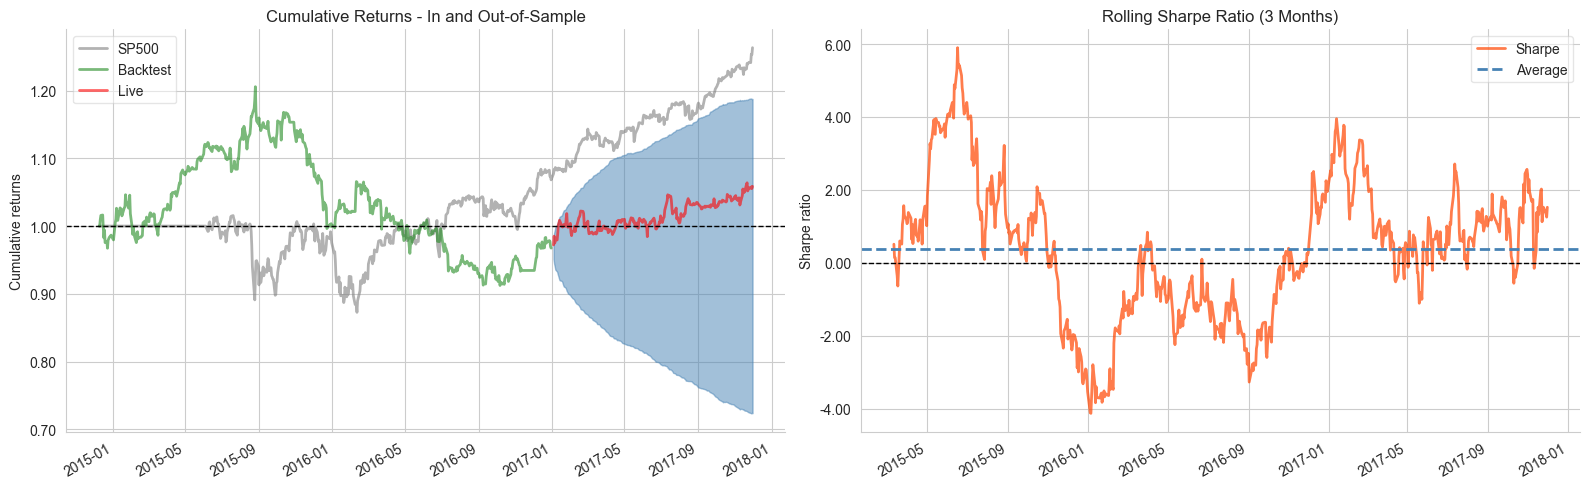

In [274]:
benchmark_aligned = benchmark.reindex(returns.index)

# Align benchmark to returns index
fig, axes = plt.subplots(ncols=2, figsize=(16, 5))
plot_rolling_returns(returns,
                     factor_returns=benchmark_aligned,
                     live_start_date=LIVE_DATE,
                     logy=False,
                     cone_std=2,
                     legend_loc='best',
                     volatility_match=False,
                     cone_function=forecast_cone_bootstrap,
                    ax=axes[0])
plot_rolling_sharpe(returns, ax=axes[1], rolling_window=63)
axes[0].set_title('Cumulative Returns - In and Out-of-Sample')
axes[1].set_title('Rolling Sharpe Ratio (3 Months)')
sns.despine()
fig.tight_layout();

In [275]:
returns

2014-12-09 00:00:00+00:00    0.000000e+00
2014-12-10 00:00:00+00:00    2.220446e-16
2014-12-11 00:00:00+00:00    9.498995e-03
2014-12-12 00:00:00+00:00    6.176584e-03
2014-12-15 00:00:00+00:00    5.786405e-04
                                 ...     
2017-11-24 00:00:00+00:00    4.582185e-03
2017-11-27 00:00:00+00:00   -7.924929e-04
2017-11-28 00:00:00+00:00    1.846090e-03
2017-11-29 00:00:00+00:00   -2.161857e-03
2017-11-30 00:00:00+00:00    2.895788e-03
Name: returns, Length: 751, dtype: float64

In [276]:
benchmark

DATE
2015-06-04 00:00:00+00:00         NaN
2015-06-05 00:00:00+00:00   -0.001436
2015-06-08 00:00:00+00:00   -0.006474
2015-06-09 00:00:00+00:00    0.000418
2015-06-10 00:00:00+00:00    0.012042
                               ...   
2017-12-26 00:00:00+00:00   -0.001058
2017-12-27 00:00:00+00:00    0.000791
2017-12-28 00:00:00+00:00    0.001834
2017-12-29 00:00:00+00:00   -0.005183
2018-01-01 00:00:00+00:00    0.000000
Name: SP500, Length: 673, dtype: float64

Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,24.33,2015-08-26,2016-10-06,NaT,NaN
1,6.75,2015-01-22,2015-02-09,2015-04-08,55
2,4.82,2014-12-15,2014-12-23,2015-01-07,18
3,3.85,2015-06-08,2015-07-17,2015-07-31,40
4,2.93,2015-08-07,2015-08-12,2015-08-19,9


Stress Events,mean,min,max
Fall2015,0.01%,-3.05%,1.66%
New Normal,0.01%,-3.05%,2.65%


Top 10 long positions of all time,max
sid,
TGT,9.66%
IBM,9.61%
AAPL,9.52%
AMD,9.46%
PRGO,9.42%
ORLY,9.31%
ESRX,9.30%
VLO,9.29%
NFLX,9.29%


Top 10 short positions of all time,max
sid,
APC,-9.52%
FCX,-9.47%
HAL,-9.39%
VZ,-9.28%
ALTR,-9.27%
T,-9.25%
EBAY,-9.24%
KR,-9.23%
VLO,-9.22%


Top 10 positions of all time,max
sid,
TGT,9.66%
IBM,9.61%
APC,9.52%
AAPL,9.52%
FCX,9.47%
AMD,9.46%
PRGO,9.42%
HAL,9.39%
ORLY,9.31%


Summary stats,All trades,Short trades,Long trades
Total number of round_trips,12066.00,6159.00,5907.00
Percent profitable,0.48,0.42,0.54
Winning round_trips,5806.00,2615.00,3191.00
Losing round_trips,6188.00,3509.00,2679.00
Even round_trips,72.00,35.00,37.00


PnL stats,All trades,Short trades,Long trades
Total profit,$28935.04,$-218276.77,$247211.80
Gross profit,$3501494.87,$1647505.13,$1853989.74
Gross loss,$-3472559.83,$-1865781.90,$-1606777.94
Profit factor,$1.01,$0.88,$1.15
Avg. trade net profit,$2.40,$-35.44,$41.85
Avg. winning trade,$603.08,$630.02,$581.01
Avg. losing trade,$-561.18,$-531.71,$-599.77
Ratio Avg. Win:Avg. Loss,$1.07,$1.18,$0.97
Largest winning trade,$14228.10,$14228.10,$10012.13
Largest losing trade,$-25762.15,$-17154.37,$-25762.15


Duration stats,All trades,Short trades,Long trades
Avg duration,6 days 10:49:46.274158793,6 days 15:14:54.884559181,6 days 06:13:18.982563060
Median duration,4 days 00:00:00,4 days 00:00:00,3 days 00:00:00
Longest duration,102 days 00:00:00,102 days 00:00:00,87 days 00:00:00
Shortest duration,0 days 03:00:01,0 days 03:00:01,0 days 03:00:01


Return stats,All trades,Short trades,Long trades
Avg returns all round_trips,0.00%,-0.00%,0.00%
Avg returns winning,0.06%,0.06%,0.06%
Avg returns losing,-0.05%,-0.05%,-0.06%
Median returns all round_trips,-0.00%,-0.00%,0.00%
Median returns winning,0.02%,0.02%,0.02%
Median returns losing,-0.01%,-0.01%,-0.02%
Largest winning trade,1.31%,1.31%,0.96%
Largest losing trade,-2.46%,-1.23%,-2.46%


Symbol stats,AAL,AAOI,AAPL,ABBV,ABT,ACN,ADBE,ADI,ADP,ADSK,AET,AGN,AIG,ALTR,ALXN,AMAT,AMBA,AMD,AMGN,AMT,AMZN,ANTM,APA,APC,APD,ARNC,ATVI,AVGO,AXP,AZO,BA,BAC,BAX,BBY,BDX,BIDU,BIIB,BK,BMY,BP,BSX,C,CAT,CB,CCE,CCI,CCL,CELG,CHK,CHTR,CI,CL,CMCSA,CMG,CMI,CNC,COF,COL,COP,COST,COTY,CRM,CSCO,CSX,CTL,CTSH,CVS,CVX,CXO,DAL,DE,DFS,DG,DHR,DIS,DISH,DLR,DLTR,DTV,DUK,DVN,EA,EBAY,EFX,EL,EMR,ENDP,EOG,EQIX,EQT,ESRX,EXPE,F,FB,FCX,FDX,FL,FLT,FOXA,FTI,GE,GILD,GM,GOOG,GOOGL,GPN,GS,GWW,HAL,HCA,HD,HES,HON,HPQ,HSY,HTZ,HUM,IBM,ILMN,INCY,INTC,INTU,ISRG,JCI,JNJ,JPM,KHC,KMI,KO,KORS,KR,LB,LDOS,LL,LLY,LMT,LOW,LRCX,LUV,LVS,LYB,M,MA,MAR,MCD,MCHP,MCK,MDLZ,MDT,MET,MGM,MMM,MO,MPC,MRK,MRO,MS,MSFT,MU,MYL,NEE,NEM,NFLX,NKE,NOV,NVDA,NWL,OKE,ORCL,ORLY,OXY,PANW,PCG,PEP,PFE,PG,PM,PNC,PRGO,PSX,PXD,PYPL,QCOM,RAD,RCL,REGN,RF,RIG,SBAC,SBUX,SCHW,SE,SHW,SIG,SLB,SO,SPG,SRPT,STZ,SWKS,SWN,SYF,SYY,T,TAP,TDG,TGT,TJX,TMO,TMUS,TSLA,TSN,TWTR,TXN,UAA,UAL,ULTA,UNH,UNP,UPS,URI,USB,UTX,V,VLO,VMW,VRTX,VRX,VZ,WBA,WDC,WFC,WLL,WMB,WMT,WYNN,X,XOM,YELP,YUM
Avg returns all round_trips,-0.00%,0.00%,-0.01%,-0.01%,-0.02%,0.02%,0.00%,0.02%,0.10%,0.06%,0.00%,-0.01%,-0.00%,0.01%,-0.00%,-0.01%,0.05%,-0.04%,0.01%,0.04%,0.01%,-0.01%,-0.03%,0.01%,-0.01%,0.10%,0.02%,0.01%,0.00%,-0.00%,0.01%,-0.01%,-0.00%,0.00%,0.00%,0.02%,0.01%,-0.02%,-0.00%,-0.01%,-0.02%,0.00%,0.01%,-0.06%,-0.07%,-0.01%,-0.03%,0.01%,-0.02%,-0.01%,-0.02%,0.06%,-0.00%,0.01%,-0.16%,0.13%,0.14%,0.03%,-0.01%,-0.01%,0.05%,0.01%,0.00%,-0.01%,-0.35%,0.02%,0.00%,-0.00%,-0.04%,0.01%,0.02%,-0.00%,-0.03%,0.00%,-0.01%,-0.02%,-0.04%,0.00%,-0.00%,0.04%,0.00%,0.01%,-0.02%,0.05%,-0.11%,0.00%,0.05%,-0.00%,0.02%,0.00%,-0.00%,0.02%,-0.01%,0.01%,-0.02%,-0.00%,-0.07%,0.08%,-0.01%,0.16%,0.01%,0.02%,-0.00%,-0.00%,0.01%,0.02%,-0.00%,-0.07%,0.00%,0.01%,-0.00%,-0.07%,0.03%,-0.12%,0.01%,0.15%,0.02%,-0.01%,0.05%,0.00%,-0.00%,-0.01%,0.02%,0.03%,-0.01%,-0.00%,-0.00%,0.01%,0.01%,-0.05%,0.01%,0.03%,0.01%,-0.08%,0.01%,0.01%,-0.00%,-0.01%,0.00%,0.01%,0.00%,-0.03%,0.01%,-0.00%,0.00%,-0.07%,0.02%,0.01%,-0.01%,-0.02%,0.00%,-0.00%,-0.01%,-0.03%,0.01%,-0.02%,-0.00%,0.01%,-0.00%,-0.01%,0.10%,-0.03%,-0.01%,0.01%,0.02%,-0.00%,-0.01%,-0.01%,0.02%,0.00%,0.01%,0.04%,0.01%,0.00%,-0.01%,0.01%,0.01%,0.02%,0.02%,0.03%,-0.01%,0.01%,-0.00%,-0.04%,-0.04%,0.01%,0.05%,0.26%,0.08%,-0.03%,0.00%,0.05%,-0.00%,-0.08%,0.01%,-0.01%,0.02%,0.10%,0.01%,-0.01%,-0.05%,0.03%,0.03%,0.00%,0.02%,0.06%,-0.00%,-0.01%,0.04%,0.01%,0.00%,0.00%,-0.02%,-0.00%,0.01%,0.01%,0.04%,0.00%,-0.00%,0.01%,-0.04%,0.02%,-0.00%,0.01%,-0.00%,0.13%,0.04%,-0.05%,-0.01%,0.01%,-0.00%,0.00%,0.10%,0.04%,-0.00%,-0.00%,-0.02%,0.00%,-0.16%,0.06%
Avg returns winning,0.07%,0.12%,0.04%,0.03%,0.03%,0.05%,0.06%,0.07%,0.11%,0.06%,0.05%,0.05%,0.02%,0.14%,0.11%,0.05%,0.25%,0.09%,0.07%,0.10%,0.06%,0.07%,0.06%,0.08%,NaN,0.10%,0.07%,0.08%,0.03%,0.06%,0.04%,0.04%,0.02%,0.04%,0.04%,0.11%,0.07%,0.00%,0.06%,0.08%,NaN,0.04%,0.07%,NaN,0.16%,0.04%,NaN,0.07%,0.09%,0.08%,0.03%,0.06%,0.03%,0.09%,NaN,0.13%,0.14%,0.03%,0.07%,0.03%,0.07%,0.05%,0.04%,0.06%,NaN,0.04%,0.04%,0.04%,NaN,0.07%,0.04%,0.01%,0.00%,0.01%,0.03%,NaN,NaN,0.05%,NaN,0.06%,0.12%,0.05%,0.04%,0.09%,NaN,0.01%,0.10%,0.07%,0.18%,0.08%,0.05%,0.07%,0.04%,0.05%,0.13%,0.03%,NaN,0.18%,0.04%,0.16%,0.04%,0.06%,0.05%,0.06%,0.07%,0.02%,0.04%,NaN,0.06%,0.04%,0.04%,0.11%,0.04%,NaN,0.01%,0.15%,0.06%,0.05%,0.18%,0.08%,0.04%,NaN,0.06%,0.05%,0.03%,0.04%,0.05%,0.08%,0.03%,0.14%,0.03%,0.03%,0.06%,0.01%,0.06%,0.05%,0.05%,0.11%,0.07%,0.04%,0.06%,0.06%,0.05%,0.03%,0.04%,NaN,0.07%,0.05%,0.05%,0.04%,0.07%,0.02%,0.03%,0.03%,0.05%,0.08%,0.05%,0.05%,0.09%,0.08%,0.10%,0.07%,0.10%,0.06%,0.14%,0.09%,0.00%,0.01%,0.05%,0.06%,0.04%,0.07%,0.04%,0.02%,0.06%,0.03%,0.05%,0.04%,0.12%,0.19%,0.05%,0.07%,0.05%,0.04%,0.14%,0.10%,0.06%,0.26%,0.08%,0.06%,0.03%,0.05%,0.02%,0.13%,0.06%,NaN,0.05%,0.12%,0.05%,0.07%,NaN,0.08%,0.10%,0.03%,0.10%,0.07%,0.05%,0.03%,0.04%,0.02%,0.10%,0.01%,0.09%,0.03%,0.09%,0.09%,0.07%,0.04%,0.04%,0.02%,0.00%,0.03%,0.03%,0.04%,0.05%,0.13%,0.07%,0.09%,0.03%,0.06%,0.06%,0.04%,0.14%,0.11%,0.04%,0.09%,0.10%,0.03%,NaN,0.09%
A

Profitability (PnL / PnL total) per name,
symbol,
BIDU,100.15%
WLL,71.84%
WMB,65.74%
GILD,62.39%
ORCL,58.63%
ATVI,57.87%
TDG,52.79%
NKE,49.17%
PANW,44.85%


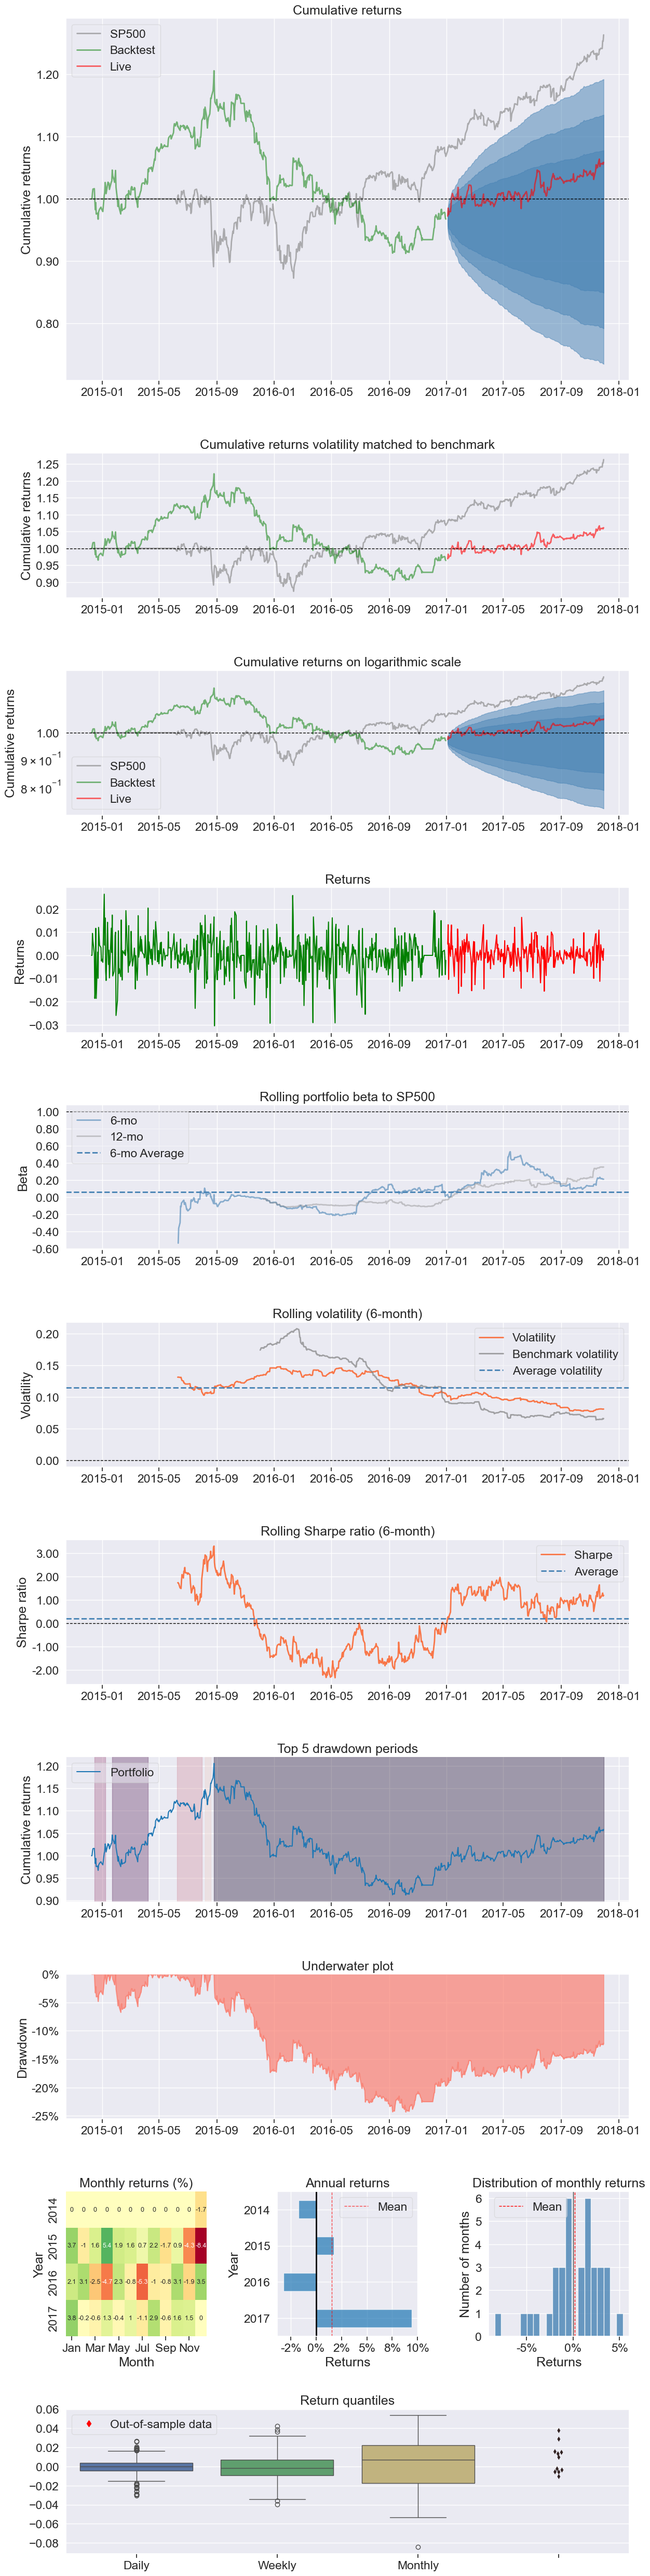

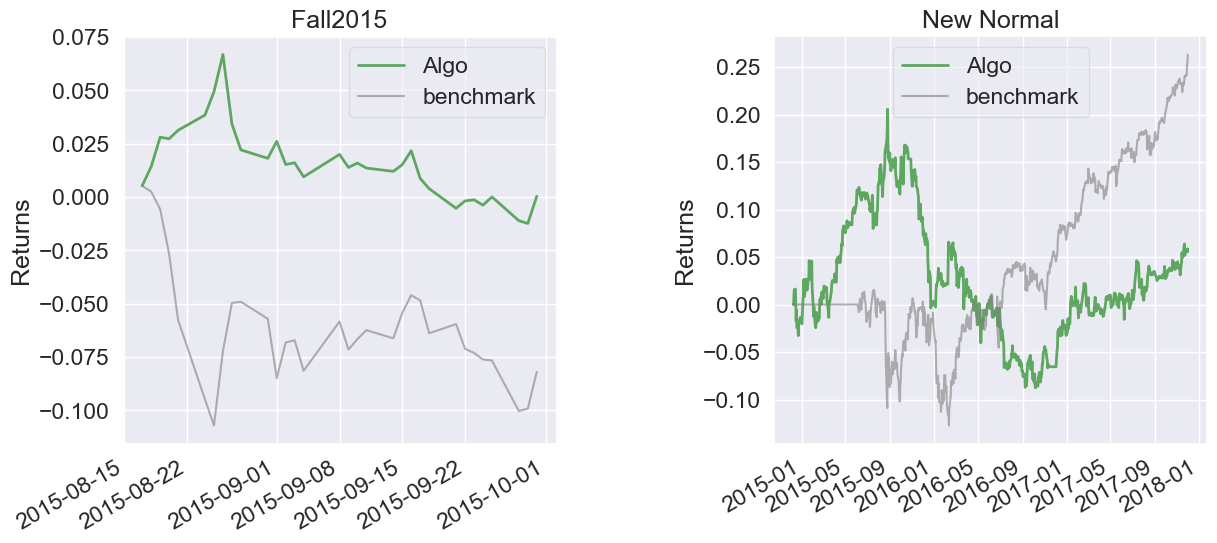

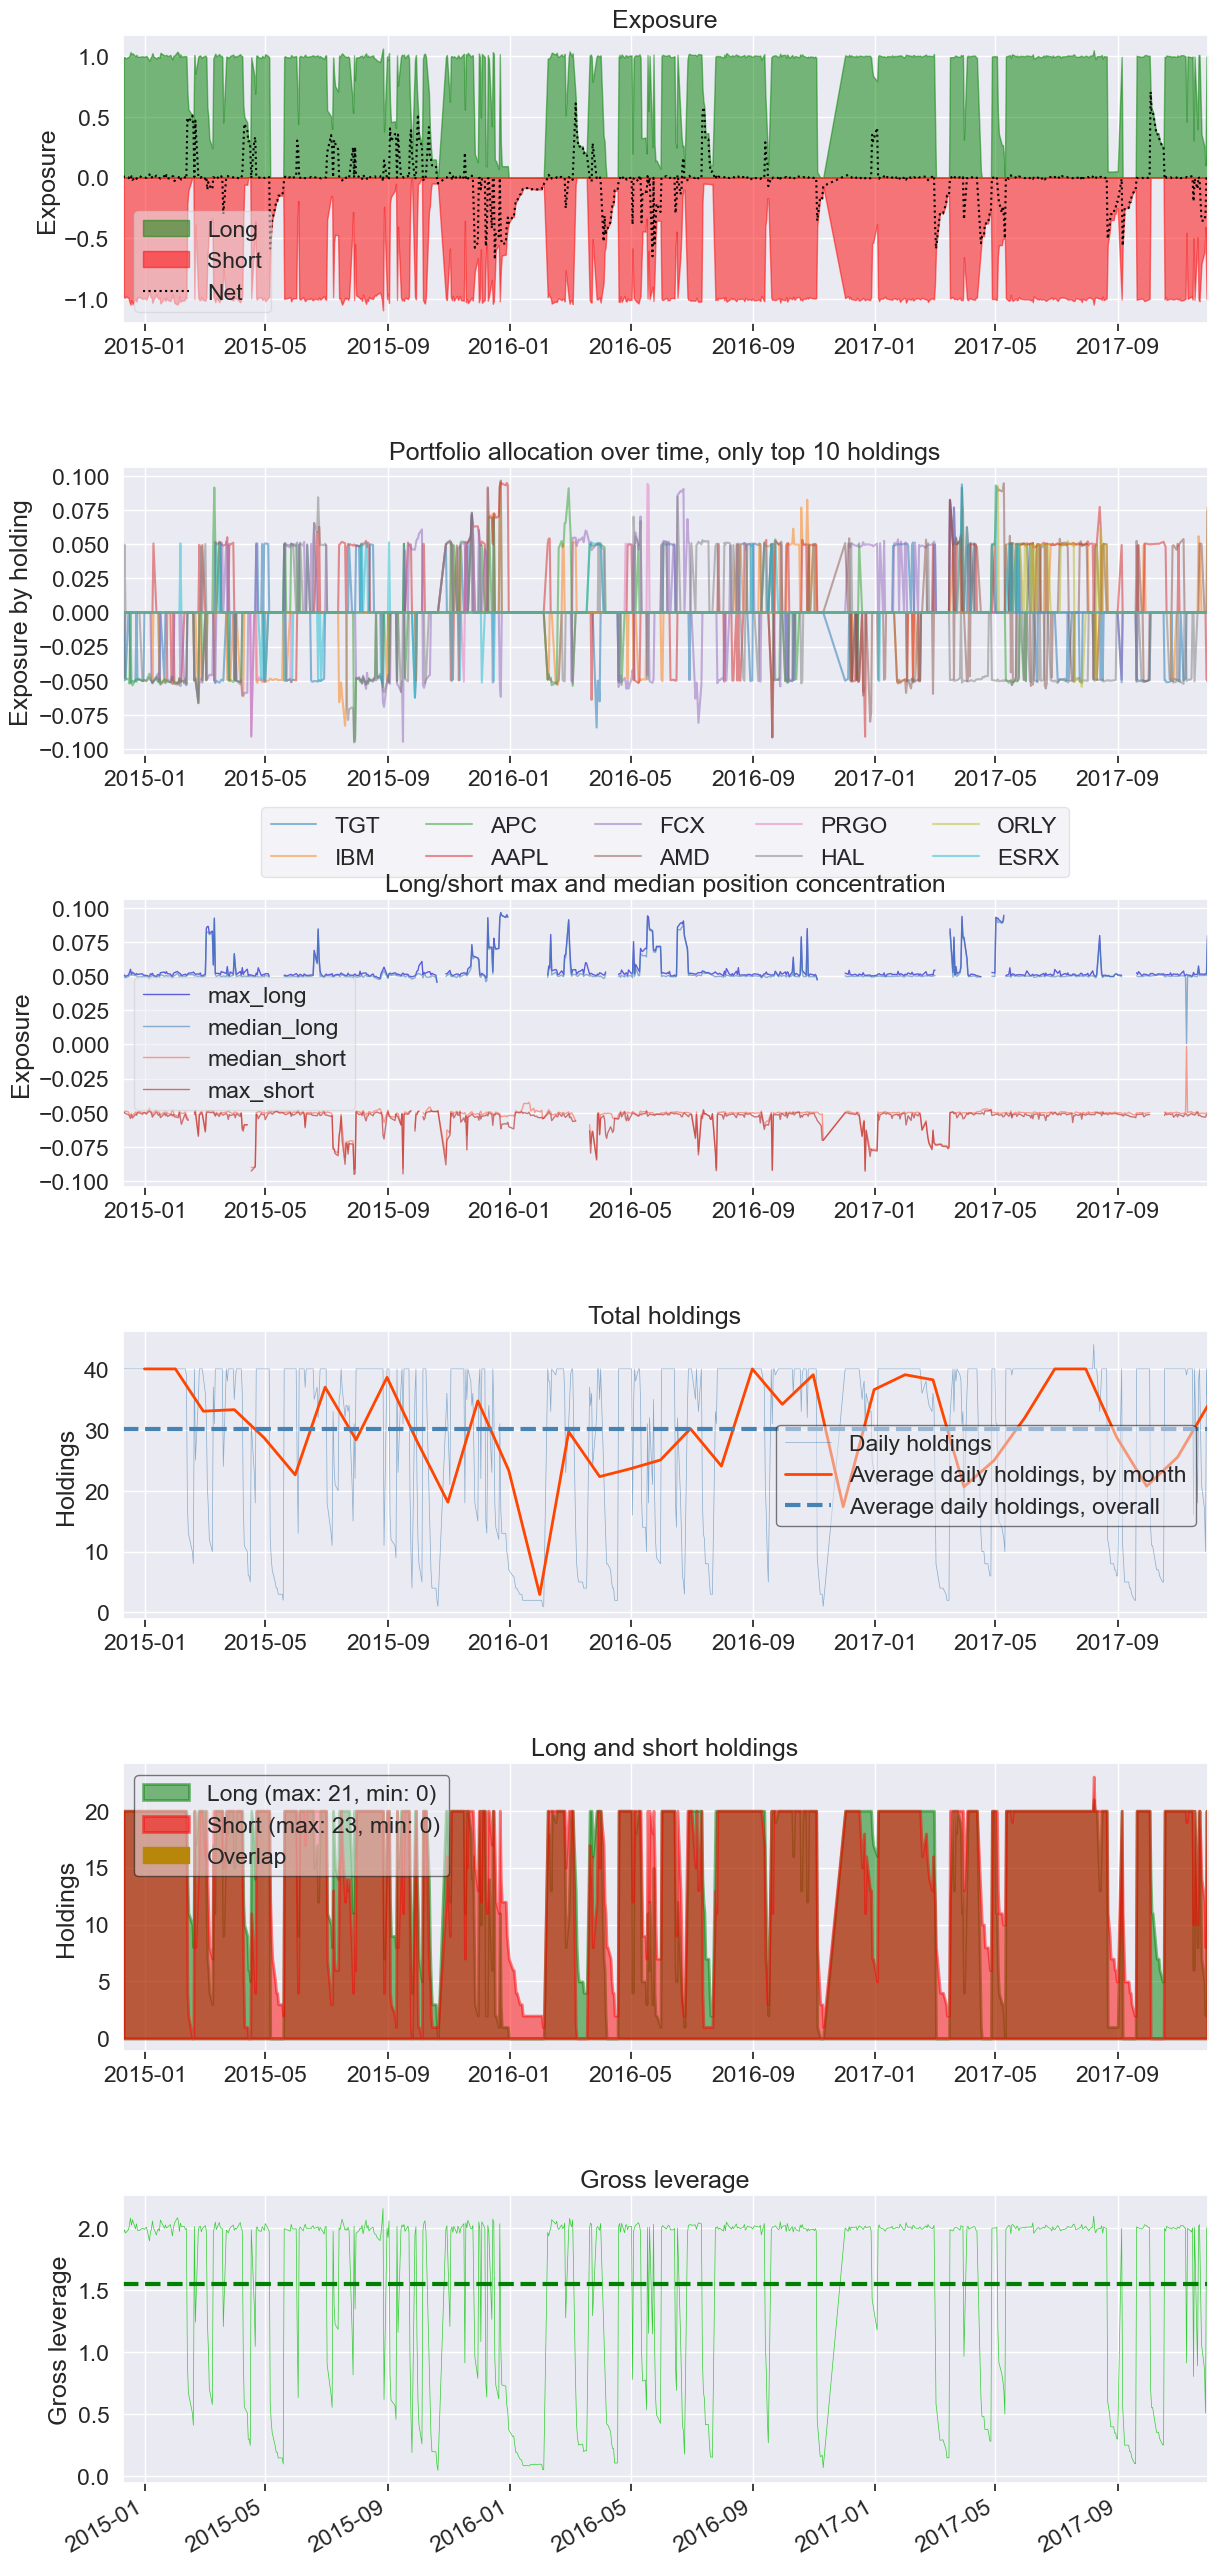

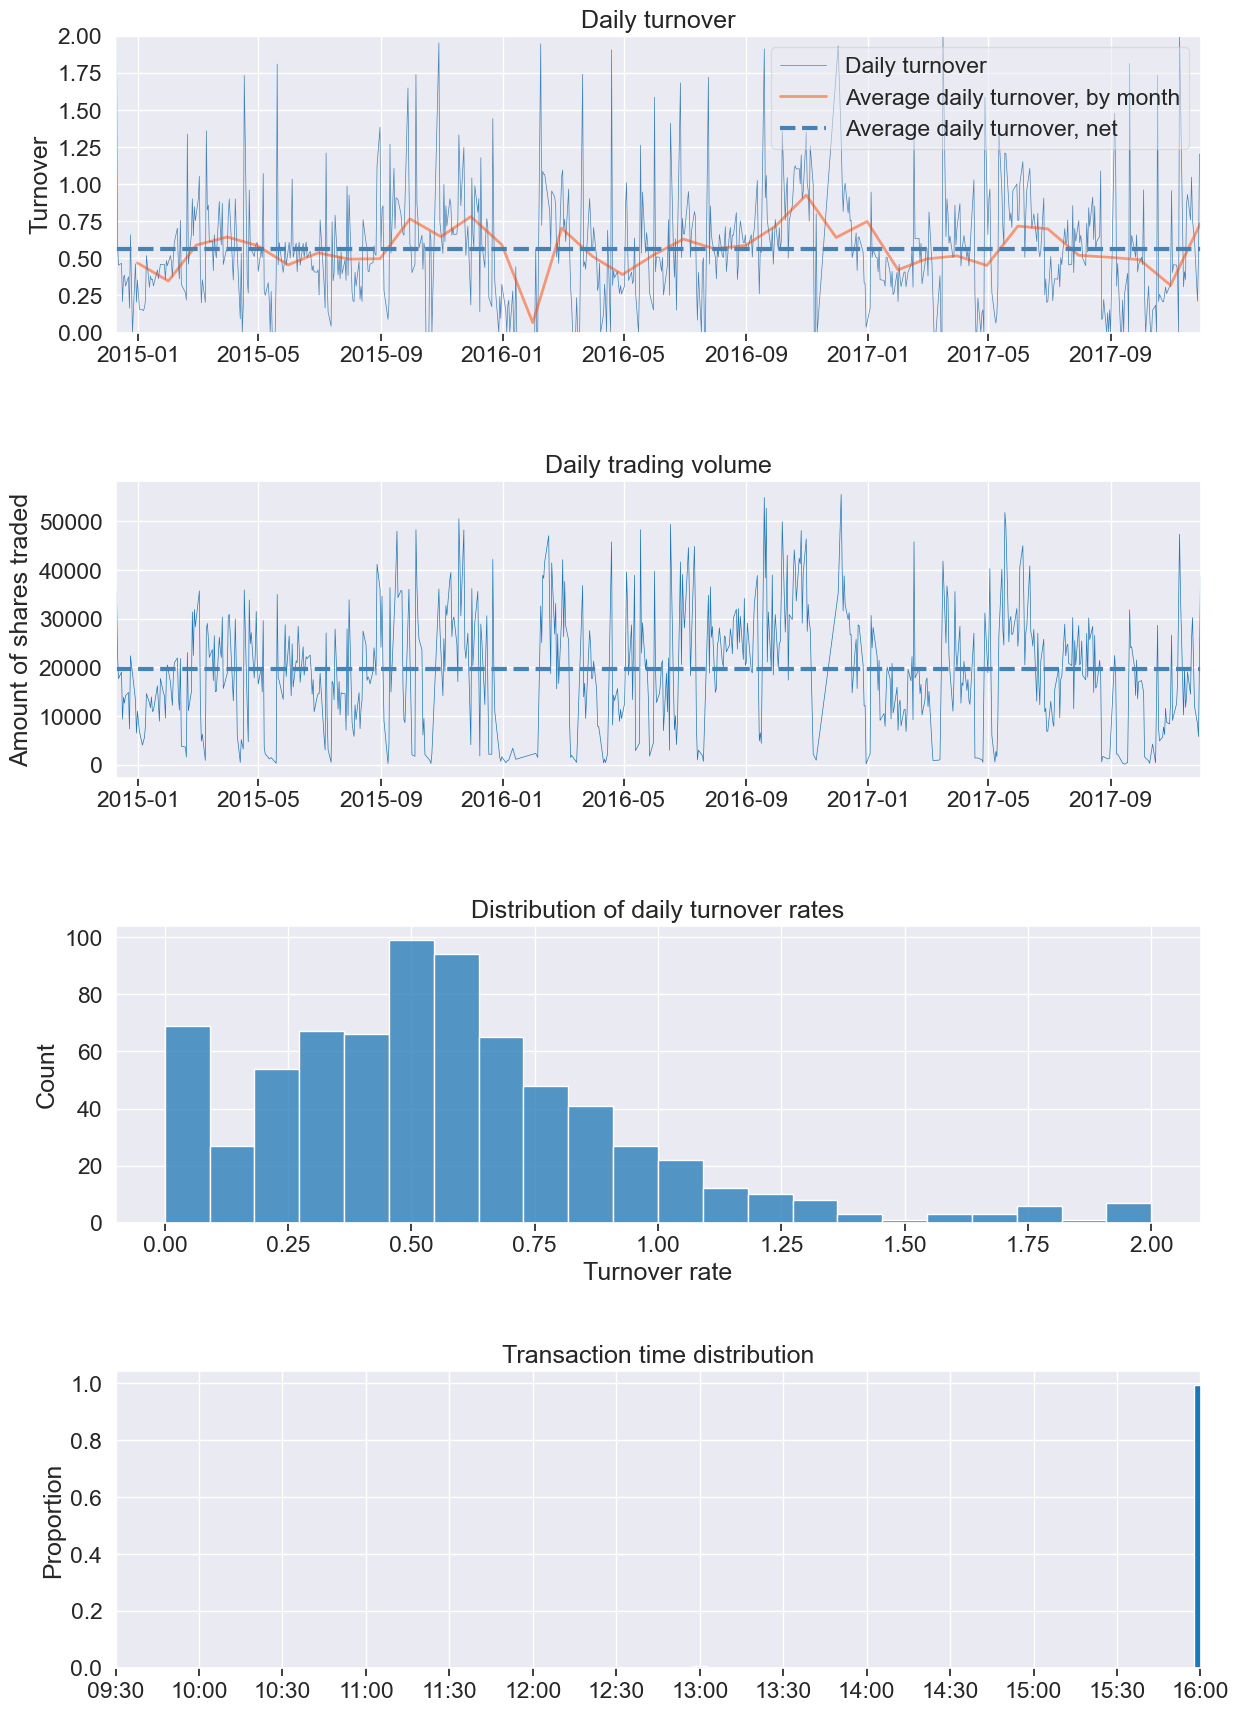

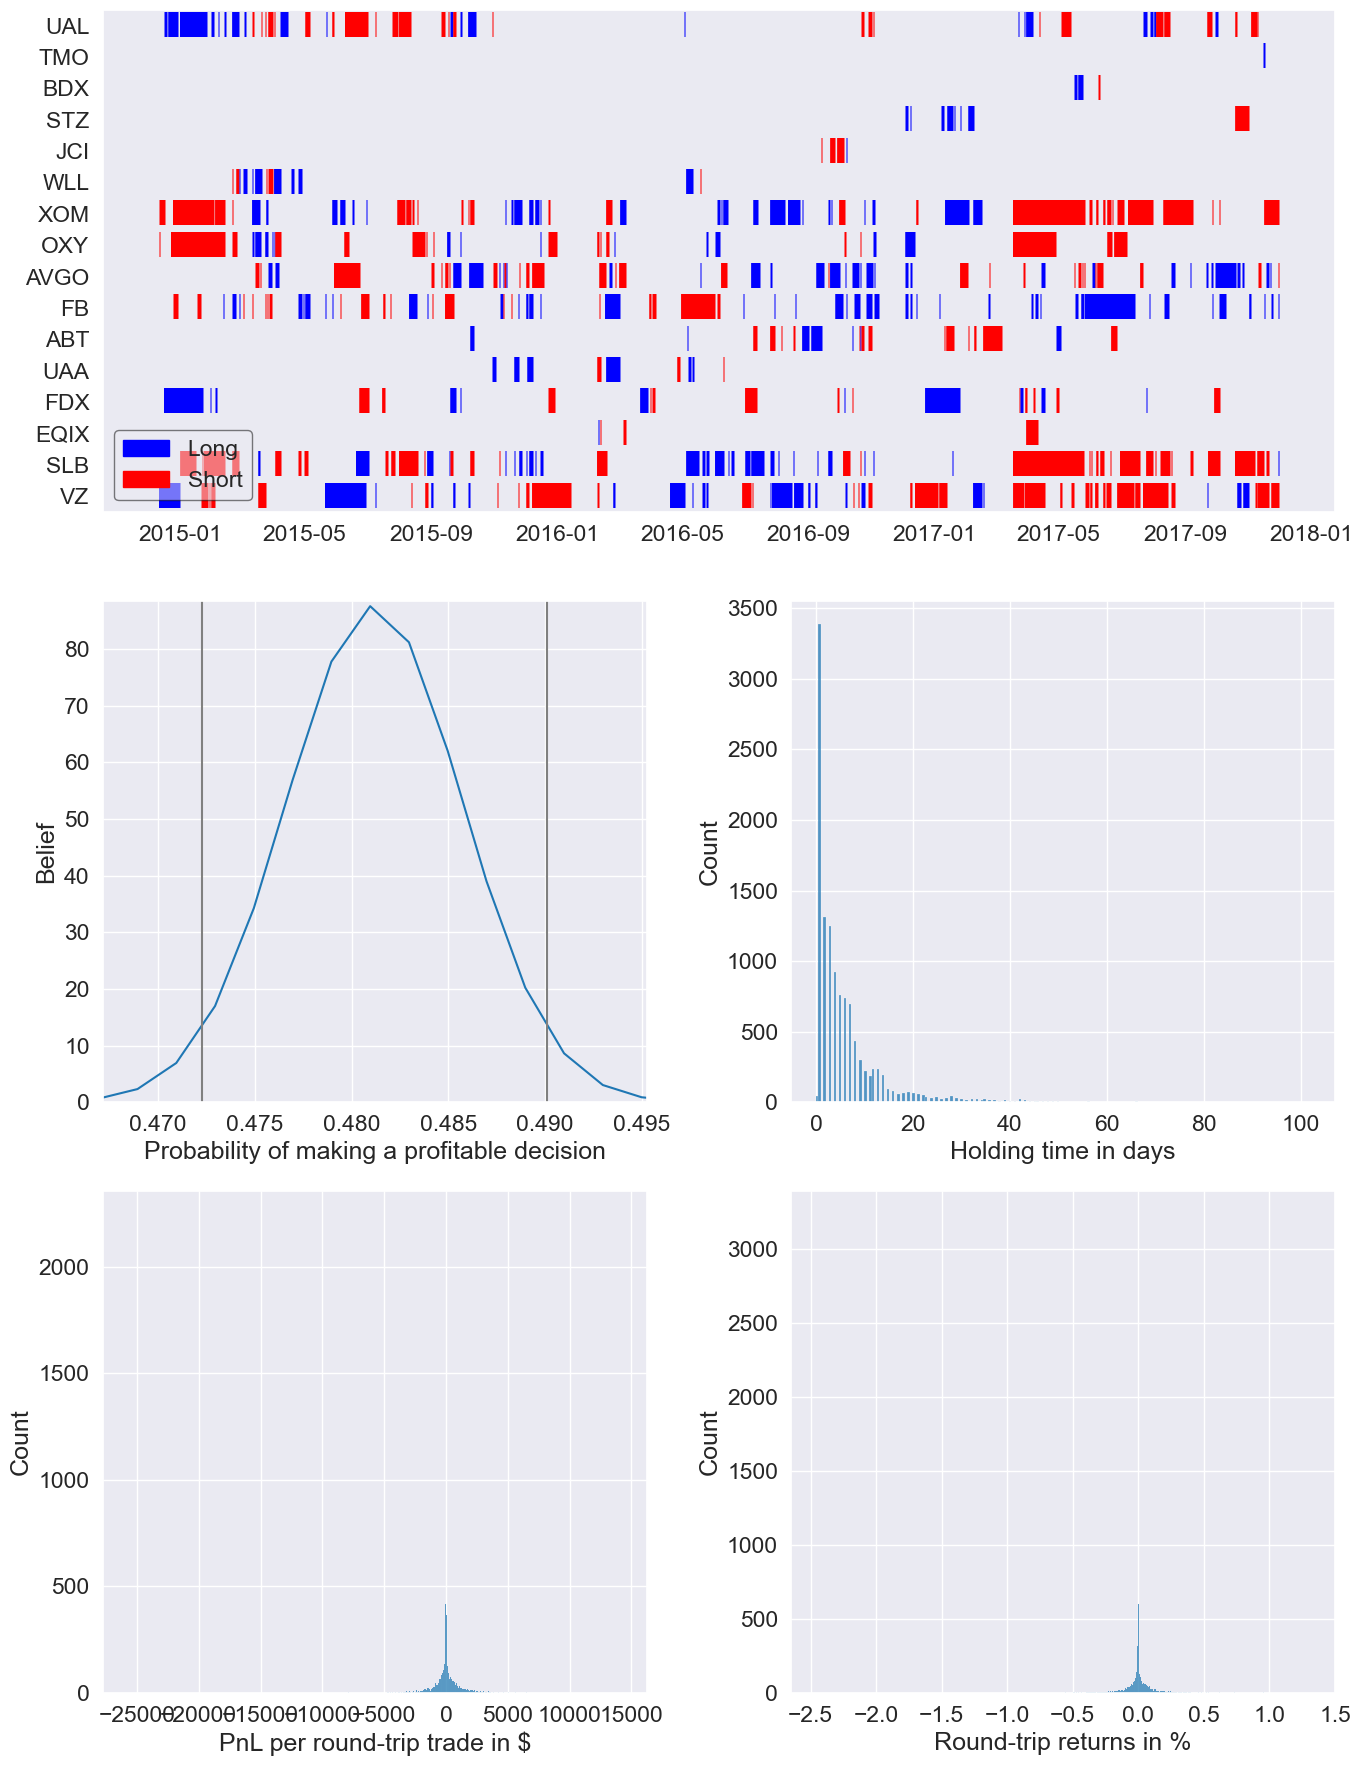

In [277]:
benchmark_aligned = benchmark.reindex(returns.index)

pf.create_full_tear_sheet(returns, 
                          positions=positions, 
                          transactions=transactions,
                          benchmark_rets=benchmark_aligned,
                          live_start_date=LIVE_DATE, 
                          round_trips=True)